In [3]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from dictor import dictor
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import  NA

def extract_experiment_data(json_file):
    variant = Path(json_file).relative_to('./results').parts[0]

    with open(json_file, 'r') as f:
        data = json.load(f)

    data['variant'] = variant
    # with open(json_file, 'w') as f:
    #     json.dump(data, f, indent=4)

    # Extract metadata
    model_family = dictor(data, 'args.model_family')
    peft_method = dictor(data, 'args.peft')
    task = dictor(data, 'args.task')

    # for mnli, need patching.
    if 'eval_runtime' in data:
        eval_runtime = data.get('eval_runtime')
    else:
        eval_runtime_history = []
        for item in data['log_history']:
            if 'eval_runtime' in item:
                eval_runtime_history.append(item['eval_runtime'])
        eval_runtime = sum(eval_runtime_history) / len(eval_runtime_history)

    # Get training-specific metrics
    trainable_params = dictor(data, 'train.trainable_params_count', NA)
    train_runtime = dictor(data, 'train.train_time', NA)

    # Calculate Average GPU Memory (Allocated)
    memory_list = dictor(data, 'train.memory_allocated', [])
    avg_memory = np.mean(memory_list) if memory_list else NA

    rank = dictor(data, 'args.rank')
    if 'mrlora' in peft_method:
        rank = 2*rank - 1 # r = 2*R - 1
        
    # Get metrics
    # Some tasks use eval_accuracy, others eval_matthews_correlation
    for key in TASK_METRIC[task]:
        if key in data:
            accuracy = data[key]
            yield {
                "family": model_family,
                "peft": peft_method,
                "task": task,
                "variant": variant,
                "value": round(accuracy, 4),
                "metric": key,
                "params": round(trainable_params, 4),
                "traintime": round(train_runtime, 2),
                "evaltime": round(eval_runtime, 2),
                "gpumem": round(avg_memory, 2),
                "rank": rank, # total rank.
                'seed': dictor(data, 'args.seed'),
            }


def aggregate_experiment_results(root_dir):
    """
    Finds all .json files under a directory recursively, extracts data,
    and concatenates them into one large DataFrame.
    """
    root_path = Path(root_dir)
    # Recursively find all JSON files
    json_files = list(root_path.rglob("*.json"))

    if not json_files:
        print(f"No JSON files found in {root_dir}")
        return pd.DataFrame()

    all_dfs = []
    for f in json_files:
        try:
            rows = extract_experiment_data(f)
            all_dfs.extend(rows)
        except Exception as e:
            print(f"Failed to extract data from {f}")
            raise e

    if not all_dfs:
        print("No valid data extracted from found files.")
        return pd.DataFrame()

    # Concatenate all individual DataFrames by row
    final_df = pd.DataFrame.from_records(all_dfs)

    return final_df

df = aggregate_experiment_results('./results/')

In [5]:
df = df.groupby('variant peft family task metric rank'.split()).mean().reset_index()
df

,variant,peft,family,task,metric,rank,value,params,traintime,evaltime,gpumem,seed
0,fft,lora,bert,mrpc,eval_accuracy,8,0.849875,109.4838,198.1575,0.08,1807.88,557.75
1,lora,adalora,bert,mrpc,eval_accuracy,8,0.838200,0.5917,549.4200,0.12,467.30,42.00
2,lora,dora,bert,mrpc,eval_accuracy,8,0.865200,0.3149,310.4900,0.12,462.42,42.00
3,lora,lora,bert,mrpc,eval_accuracy,8,0.870100,0.2964,187.6200,0.13,462.13,42.00
4,lora,olora,bert,mrpc,eval_accuracy,8,0.840700,0.2964,186.8800,0.12,462.13,42.00
5,lora,rslora,bert,mrpc,eval_accuracy,8,0.862700,0.2964,269.9800,0.15,462.13,42.00


In [7]:
df['rank'].unique(), df.family.unique(), df.peft.unique(), df.task.unique(), df.metric.unique(), df.variant.unique()

(array([8]),
 array(['BERT-b'], dtype=object),
 array(['LoRA', 'AdaLoRA', 'DoRA', 'OLoRA', 'RS-LoRA'], dtype=object),
 array(['MRPC'], dtype=object),
 array(['Acc'], dtype=object),
 array(['fft', 'LoRA'], dtype=object))

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置为 'talk' 模式，这会自动放大所有元素，非常接近论文插图的需求
sns.set_context("talk") 

# 或者手动精细调整
plt.rcParams.update({
    "font.family": "serif",  # 论文通常使用衬线字体
    "font.serif": ["Times New Roman"], # 匹配 LaTeX 默认字体
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.figsize": (8, 6) # 控制画布大小，画布越小，相对字号就越大
})

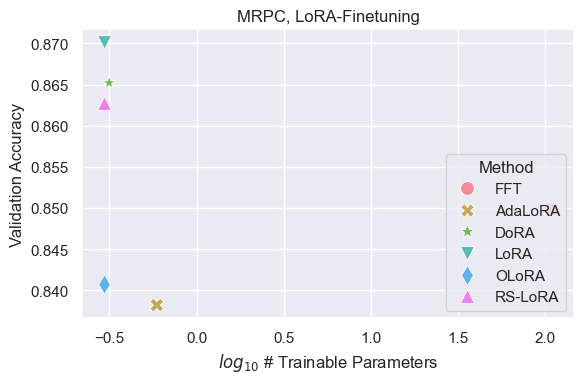

In [11]:
plotting_function(
    df,
    FILENAME = f'fig2-{VARIANT}-acc.pdf',
    YLABEL = 'Validation Accuracy',
    YVAR = 'value',
)

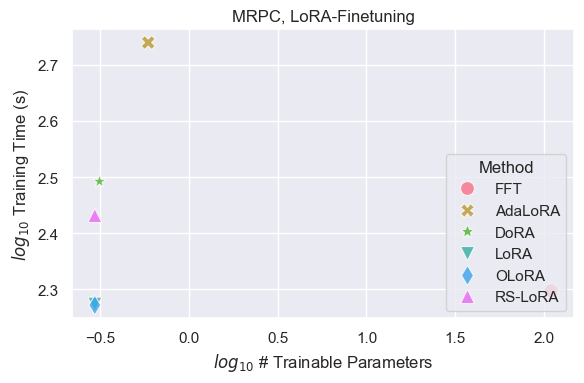

In [13]:
plotting_function(
    df,
    FILENAME = f'fig2-{VARIANT}-traintime.pdf',
    YLABEL = '$log_{10}$ Training Time (s)',
    YVAR = 'traintime',
)